In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Tuple, Dict, Any
from functools import reduce

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from transformers import MusicgenForConditionalGeneration, AutoProcessor

from captum.attr import LayerFeatureAblation

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.common import concepts_to_str
from captum.concept._utils.classifier import Classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(random_state)

torch.set_grad_enabled(True)

/home/bruno/miniconda3/envs/musicgen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Wczytanie modelu

In [2]:
processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")
model.to(device)
model = model.half()  # Convert model weights to float16
model.eval()

/home/bruno/miniconda3/envs/musicgen/lib/python3.12/site-packages/transformers/models/encodec/modeling_encodec.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)
Config of the text_encoder: <class 'transformers.models.t5.modeling_t5.T5EncoderModel'> is overwritten by shared text_encoder config: T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type"

MusicgenForConditionalGeneration(
  (text_encoder): T5EncoderModel(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): L

In [3]:
inputs = processor(
    text=["80s pop track with bassy drums and synth", "90s rock song with loud guitars and heavy drums"],
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(device)
display(inputs)

{'input_ids': tensor([[ 2775,     7,  2783,  1463,    28,  7981,    63,  5253,     7,    11,
         13353,     1,     0],
        [ 2777,     7,  2480,  2324,    28,  8002,  5507,     7,    11,  2437,
          5253,     7,     1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [4]:
from IPython.display import Audio

audio_values = model.generate(**inputs, max_new_tokens=255)
sampling_rate = model.config.audio_encoder.sampling_rate
Audio(audio_values[0].cpu().numpy(), rate=sampling_rate)

`torch.nn.functional.scaled_dot_product_attention` does not support having an empty attention mask. Falling back to the manual attention implementation. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.Note that this probably happens because `guidance_scale>1` or because you used `get_unconditional_inputs`. See https://github.com/huggingface/transformers/issues/31189 for more information.


### Bez wykorzystania metody `.generate()`

In [18]:
text = ["lofi jazz with piano and drums"]
inputs = processor(text=text, padding=True, return_tensors="pt").to(device)
inputs

{'input_ids': tensor([[   3,   40,  858,   23, 9948,   28, 8355,   11, 5253,    7,    1]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [21]:
pad_token_id = model.generation_config.pad_token_id
decoder_input_ids = (
    torch.ones(
        (inputs.input_ids.shape[0] * model.decoder.num_codebooks, 1), dtype=torch.long) * pad_token_id
).to(device)
decoder_input_ids

tensor([[2048],
        [2048],
        [2048],
        [2048]], device='cuda:0')

In [22]:
logits = model(**inputs, decoder_input_ids=decoder_input_ids).logits
logits.shape  # (bsz * num_codebooks, tgt_len, vocab_size)

torch.Size([4, 1, 2048])

### Próby obliczenia gradientu

In [42]:
model.decoder.model.decoder.layers[0].fc1.requires_grad_(True)

Linear(in_features=1024, out_features=4096, bias=False)

In [40]:
for param in model.decoder.model.decoder.parameters():
    param.requires_grad = True
    print(param.shape)
    print(param.grad_fn)
    if param.grad is not None:
        print(param.grad.shape)
        break

torch.Size([2049, 1024])
None
torch.Size([2049, 1024])
None
torch.Size([2049, 1024])
None
torch.Size([2049, 1024])
None
torch.Size([2048, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024])
None
torch.Size([1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024])
None
torch.Size([1024])
None
torch.Size([4096, 1024])
None
torch.Size([1024, 4096])
None
torch.Size([1024])
None
torch.Size([1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024])
None
torch.Size([1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024, 1024])
None
torch.Size([1024])
None
torch.Size([1024])
None
torch.Size([4096, 1024])
None
torch.Size([1024, 4096])
None
torch.Size

In [48]:
inputs["input_ids"].grad_fn

In [ ]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print(os.environ["PYTORCH_CUDA_ALLOC_CONF"])# = "expandable_segments:True"

inputs = processor(
    text=["jazz piano trio with walking bass"],
    max_length=256,
    padding=True,
    return_tensors="pt",
    truncation=True,
)
input_ids = inputs.input_ids
attention_mask = inputs.attention_mask

torch.cuda.set_per_process_memory_fraction(0.8)  # Limit to 80% GPU memory
torch.cuda.empty_cache()  # Clear cached memory before generation

model.train()  # Enable training mode
model = model.half()  # Convert model weights to float16
model.gradient_checkpointing_enable()
with torch.amp.autocast('cuda'):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    input_ids.requires_grad = True  # Enable gradient tracking on input_ids
    attention_mask.requires_grad = True  # Enable gradient tracking on attention_mask
    
    # Single-step forward pass example
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=255,
        output_hidden_states=True,
        return_dict_in_generate=True,
        use_cache=False,
    )
    
    print(outputs)

    # Calculate loss and gradients
    loss = outputs.decoder_hidden_states[0][0].mean()  # Replace with actual loss function
    loss.backward()

# Access gradients
input_gradients = input_ids.grad

expandable_segments:True


AttributeError: 'MusicgenForCausalLM' object has no attribute 'embed_tokens'

## Analiza TCAV

In [3]:
class ConceptDataset(Dataset):
    def __init__(self, caption_column: str, df: pd.DataFrame, concept_tensor: torch.Tensor):
        self.df = df
        self.caption_column = caption_column
        self.concept_tensor = concept_tensor.to(device)
        self.text = self.df[self.caption_column].tolist()

        inputs = processor(
            text=self.text,
            max_length=256,
            padding=True,
            return_tensors="pt",
            truncation=True,
        )
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        self.input_ids = input_ids
        self.attention_mask = attention_mask

    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.input_ids[idx], self.attention_mask[idx], self.concept_tensor

In [4]:
class ConceptClassifier(Classifier):
    def __init__(self, *args, **kwargs):
        self.lm = SGDClassifier(
            *args,
            **kwargs,
            random_state=random_state,
        )

    def train_and_eval(self, dataloader, test_split_ratio = 0.33, **kwargs) -> dict:
        X = []
        y = []
        for batch in dataloader:
            x, y_batch = batch
            X.append(x.cpu().numpy())
            y.append(y_batch.cpu().numpy())

        max_len = max([x.shape[1] for x in X])
        X = [np.pad(x, ((0, 0), (0, max_len - x.shape[1])), mode='constant') for x in X]

        X = np.concatenate(X)
        y = np.concatenate(y)

        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=test_split_ratio,
            random_state=random_state,
        )

        self.lm.fit(X_train, y_train)
        y_pred = self.lm.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        return {"accuracy": acc}

    def weights(self) -> torch.Tensor:
        if len(self.lm.coef_) == 1:
            # if there are two concepts, there is only one label.
            # We split it in two.
            return torch.tensor([-1 * self.lm.coef_[0], self.lm.coef_[0]])
        else:
            return torch.tensor(self.lm.coef_)

    def classes(self) -> list[int]:
        return list(self.lm.classes_)

In [5]:
class CustomMusicGen:
    def __init__(self, model, processor, max_new_tokens=256):
        self.model = model
        self.processor = processor
        self.max_new_tokens = max_new_tokens

        self.model.eval()
        self.model.to(device)

    def __call__(self, input_ids, attention_mask, concept_tensor):
        return self.forward(input_ids, attention_mask, concept_tensor)

    def forward(self, input_ids, attention_mask, concept_tensor):
        torch.cuda.empty_cache()
        with torch.amp.autocast('cuda'):
            audio_values = self.model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=self.max_new_tokens,
                # output_hidden_states=True,
                # return_dict_in_generate=True,
                # use_cache=False,
            )
        return audio_values[0]

In [6]:
def select_samples(
    df: pd.DataFrame,
    concept: str,
    genre: str,
    num_samples: int,
):
    _df = df.copy()
    _df = _df[_df[f"is_genre_{genre}"] == 1]
    _df = _df[_df[f"is_{concept}"] == 1]
    _df = _df.sample(num_samples, random_state=random_state)
    return _df

def select_random_samples(
    df: pd.DataFrame,
    num_samples: int,
):
    _df = df.copy()
    _df = _df.sample(num_samples, random_state=random_state)
    return _df

In [7]:
def assemble_concept(name, id, concept_name, genre, data_path, batch_size, concept_tensor, num_samples=None):
    df = pd.read_csv(data_path)
    concept_df = select_samples(
        df=df,
        concept=concept_name,
        genre=genre,
        num_samples=num_samples,
    )
    concept_dataset = ConceptDataset(
        caption_column="caption_without_genre",
        df=concept_df,
        concept_tensor=concept_tensor,
    )
    concept_dataloader = DataLoader(
        concept_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    return Concept(id=id, name=name, data_iter=concept_dataloader)

def assemble_random_concept(name, id, data_path, batch_size, concept_tensor, num_samples=None):
    df = pd.read_csv(data_path)
    concept_df = select_random_samples(
        df=df,
        num_samples=num_samples,
    )
    concept_dataset = ConceptDataset(
        caption_column="caption_without_genre",
        df=concept_df,
        concept_tensor=concept_tensor,
    )
    concept_dataloader = DataLoader(
        concept_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    return Concept(id=id, name=name, data_iter=concept_dataloader)

In [8]:
def create_experimental_set(
    concept_name,
    genre,
    data_path,
    batch_size,
    num_samples,
    experimental_set_size,
):
    experimental_set = []
    concept_tensor = torch.full(
        size=(1,),
        fill_value=0,
        dtype=torch.float32,
    )
    concept = assemble_concept(
        name=concept_name,
        id=0,
        concept_name=concept_name,
        genre=genre,
        data_path=data_path,
        batch_size=batch_size,
        concept_tensor=concept_tensor,
        num_samples=num_samples,
    )

    for i in range(1, experimental_set_size + 1):
        random_concept_tensor = torch.full(
            size=(1,),
            fill_value=i,
            dtype=torch.float32,
        )
        random_concept = assemble_random_concept(
            name=f"random_{i}",
            id=i,
            data_path=data_path,
            batch_size=batch_size,
            concept_tensor=random_concept_tensor,
            num_samples=num_samples,
        )
        experimental_set.append([concept, random_concept])
    return experimental_set

In [17]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16, rotation=45)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

### Koncept Instrumentów

In [10]:
data_path = "data/music_caps_transformed_instrument.csv"

df = pd.read_csv(data_path)
display(df)
display(df[['caption', 'caption_without_genre']])

,ytid,aspect_list,caption,is_genre_pop,is_genre_rock,is_genre_jazz,is_genre_classical,is_genre_hip-hop,is_genre_country,is_genre_electronic,...,is_emotion_playful,is_emotion_dramatic,is_emotion_eerie,is_emotion_triumphant,is_emotion_depressed,is_emotion_anxious,is_emotion_confident,is_emotion_powerful,is_emotion_moody,caption_without_genre
0,-0Gj8-vB1q4,"['low quality', 'sustained strings melody', 's...",The low quality recording features a ballad so...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The low quality recording features a ballad so...
1,-1LrH01Ei1w,"['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,This song features a rubber instrument being p...
2,-1OlgJWehn8,"['instrumental', 'white noise', 'female vocali...",This clip is three tracks playing consecutivel...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,This clip is three tracks playing consecutivel...
3,-1UWSisR2zo,"['live performance', 'poor audio quality', 'am...",A male singer sings this groovy melody. The so...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A male singer sings this groovy melody. The so...
4,-4NLarMj4xU,"['pop', 'tinny wide hi hats', 'mellow piano me...",The Pop song features a soft female vocal sing...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The song features a soft female vocal singing ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3721,zu_1zpF--Zg,"['amateur recording', 'jazz/bossa-nova', 'upri...",This audio contains someone playing jazz chord...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,This audio contains someone playing chords and...
3722,zwfo7wnXdjs,"['instrumental music', 'arabic music', 'genera...",The song is an instrumental. The song is mediu...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The song is an . The song is medium tempo with...
3723,zx_vcwOsDO4,"['instrumental', 'no voice', 'electric guitar'...",The rock music is purely instrumental and feat...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The music is purely and features an electric g...
3724,zyXa2tdBTGc,"['instrumental music', 'gospel music', 'strong...",The song is an instrumental. The song is slow ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The song is an . The song is slow tempo with a...


,caption,caption_without_genre
0,The low quality recording features a ballad so...,The low quality recording features a ballad so...
1,This song features a rubber instrument being p...,This song features a rubber instrument being p...
2,This clip is three tracks playing consecutivel...,This clip is three tracks playing consecutivel...
3,A male singer sings this groovy melody. The so...,A male singer sings this groovy melody. The so...
4,The Pop song features a soft female vocal sing...,The song features a soft female vocal singing ...
...,...,...
3721,This audio contains someone playing jazz chord...,This audio contains someone playing chords and...
3722,The song is an instrumental. The song is mediu...,The song is an . The song is medium tempo with...
3723,The rock music is purely instrumental and feat...,The music is purely and features an electric g...
3724,The song is an instrumental. The song is slow ...,The song is an . The song is slow tempo with a...


In [11]:
experimental_set = create_experimental_set(
    concept_name="instrument_guitar",
    genre="rock",
    data_path=data_path,
    batch_size=10,
    num_samples=20,
    experimental_set_size=5,
)
rock_samples = select_samples(
    df=df,
    concept="instrument_guitar",
    genre="rock",
    num_samples=20,
)
rock_text = [row["caption_without_genre"] for _, row in rock_samples.iterrows()]
inputs = processor(
    text=rock_text,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(device)

# layers=['model.decoder.model.decoder.layers.0.fc1', 'model.decoder.model.decoder.layers.0.fc2', 'model.decoder.lm_heads.0', 'model.decoder.lm_heads.1']
# layers=['model.decoder.model.decoder.layers.0.fc1']
layers=['model.decoder.lm_heads.0', 'model.decoder.lm_heads.1']

custom_model = CustomMusicGen(model, processor, max_new_tokens=256)
instrument_tcav = TCAV(
    model=custom_model,
    model_id="musicgen_small_instrument",
    classifier=ConceptClassifier(),
    layer_attr_method=LayerFeatureAblation(custom_model.forward, None),
    layers=layers,
    show_progress=True,
)


In [12]:
n_groups = 10

layer_masks = []
for layer in layers:
    layer_shape = reduce(getattr, layer.split('.'), custom_model).weight.shape[0]
    print(layer_shape)
    layer_mask = torch.zeros(layer_shape).to(device)
    group_size = layer_mask.shape[0] // n_groups
    for i in range(n_groups+1):
        layer_mask[i * group_size:(i + 1) * group_size] = i
    layer_masks.append(layer_mask)

layer_masks = (*layer_masks,)

2048
2048


In [13]:
tcav_scores = instrument_tcav.interpret(
    inputs=(inputs.input_ids, inputs.attention_mask, None),
    experimental_sets=experimental_set,
    target=0,
    layer_mask=layer_masks,
)

/home/bruno/miniconda3/envs/musicgen/lib/python3.12/site-packages/captum/concept/_core/cav.py:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(cavs_

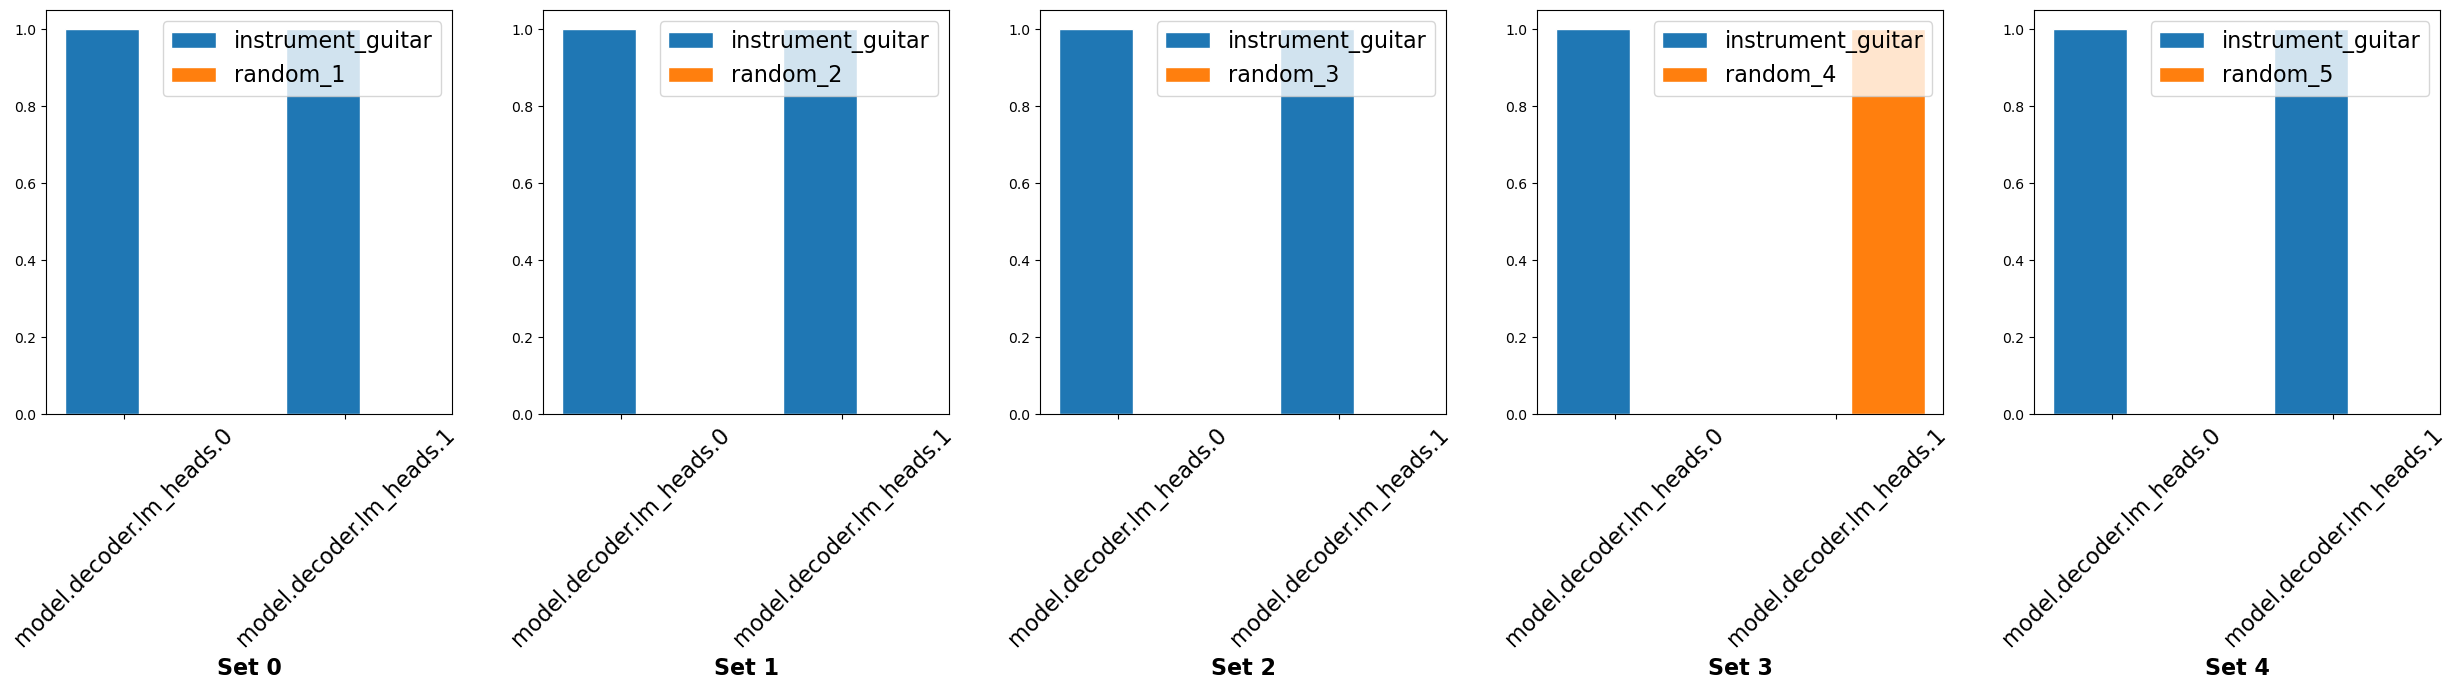

In [18]:
plot_tcav_scores(experimental_set, tcav_scores)